# Am I using GenAI too much?

It all began with this question. I was watching this Youtube video on ["Junior developers can't think anymore..."](https://youtu.be/2cV33awYGJs?si=-0geHzplqFyJ4ZnD) and somehow it resonated on me.
I have the feeling that sometimes we tend to use GenAI even when we don't need to. It's all about productivity and making things faster and more efficient. But... are we affecting our thinking by doing this? Are we simply relying too much on GenAI when in reality we don't need to? How are we using it?

In order to find an answer to this question, I used data. I took inspiration from [Chip Huyen's repo](https://github.com/chiphuyen/aie-book/blob/main/scripts/ai-heatmap.ipynb), which contains a good starting point for this analysis.

In my case, I use [ChatGPT](https://chatgpt.com/) as my daily AI Assistant. There are other really good options, particularly for coding, like [Claude](https://claude.ai/new).

## Instructions for running this notebook

If you're interested in computing the same metrics for your data, follow these steps:

1. Export your ChatGPT conversations. From your ChatGPT account, go to `Settings -> Data controls -> Export`. OpenAI will send you an e-mail with the Download link once the export is completed.
2. Unzip the data export.
3. Point `export_folder` to your exported data folder.
4. Change `local_tz` to your local timezone so that it gets the correct timestamp of each conversation.
5. Run the notebook!.

# Imports

In [29]:
import json
from collections import Counter
from datetime import datetime, timezone, timedelta
from itertools import chain
from typing import TypedDict, Any, cast

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Auxiliary Functions

In [31]:
class Message(TypedDict):
    msg_id: str
    author_role: str
    content: str
    create_time: datetime | None
    update_time: datetime | None


class Conversation(TypedDict):
    conv_id: str
    title: str
    messages: list[Message]
    create_time: datetime | None
    update_time: datetime | None


class ChatGPTConvProcessor:
    """ 
    Process and simplify conversation data from ChatGPT into a more manageable object
    """

    def process(self, conversation_data: dict[str, Any]) -> Conversation:
        return {
            "conv_id": conversation_data["conversation_id"],
            "title": conversation_data.get("title", ""),
            "messages": self._process_messages(conversation_data.get("mapping", {})),
            "create_time": unix_ts_to_local_datetime(conversation_data["create_time"]),
            "update_time": unix_ts_to_local_datetime(conversation_data["update_time"])
        }

    @staticmethod
    def _extract_message_content(message: dict | None) -> Message | None:
        """Extract relevant message information if message exists."""
        if not message:
            return None

        # Assumes there's only one part in the messages
        parts: list[str] = message.get("content", {}).get("parts", [""])
        # Get rid of parts that are multimodal_text (image and text)
        parts = [p for p in parts if type(p) is str]
        assert len(parts) <= 1

        return {
            "msg_id": message["id"],
            "author_role": message.get("author", {}).get("role"),
            "content": parts[0] if parts else "",
            "create_time": unix_ts_to_local_datetime(message["create_time"]),
            "update_time": unix_ts_to_local_datetime(message["update_time"]),
        }

    def _process_messages(self, mapping: dict[str, Any]) -> list[Message]:
        """Process all messages from the conversation mapping."""
        messages: list[Message] = []
        for node_id, node_data in mapping.items():
            # TODO: Assumes linear path in the conversation.
            message_data: Message | None = self._extract_message_content(node_data.get("message"))
            # Extract only messages from "user" or "assistant" (ignoring "system") that have content!
            if message_data and message_data["content"] and message_data["author_role"] in ["user", "assistant"]:
                messages.append(message_data)

        # Sort messages by creation time if available
        messages.sort(key=lambda x: x["create_time"] if x["create_time"] else datetime.min)
        return messages


def conversations_to_dataframe(conversations: list[Conversation]) -> pd.DataFrame:
    # Flatten the list of conversations into rows for each message
    rows: list[dict] = []
    for conv in conversations:
        for msg in conv["messages"]:
            rows.append({
                "conv_id": conv["conv_id"],
                "msg_id": msg["msg_id"],
                "conv_title": conv["title"],
                "message": msg["content"],
                "msg_chars_len": len(msg["content"]),
                "msg_words_len": len(msg["content"].split(" ")),
                "author_role": msg["author_role"],
                "msg_create_time": msg["create_time"],
                "msg_update_time": msg["update_time"],
                "conv_create_time": conv["create_time"],
                "conv_update_time": conv["update_time"],
            })

    # Create the DataFrame
    df: pd.DataFrame = pd.DataFrame(rows)
    return df


def unix_ts_to_local_datetime(orig_time: datetime | None) -> datetime | None:
    if orig_time is None:
        return None

    # Convert Unix timestamp to UTC datetime
    utc_datetime = datetime.fromtimestamp(cast(datetime, orig_time), tz=timezone.utc)
    # Convert UTC datetime to local timezone
    return utc_datetime.astimezone(pytz.timezone(LOCAL_TZ))


def clean(query: str) -> str:
    """ Performs some basic cleanup"""
    en_stopwords: set[str] = set(nltk.corpus.stopwords.words('english'))
    es_stopwords: set[str] = set(nltk.corpus.stopwords.words('spanish'))
    stopwords: set[str] = es_stopwords.union(en_stopwords)
    clean_query: str = query.lower().strip()
    query_parts: list[str] = clean_query.split(" ")
    query_parts = [qp for qp in query_parts if qp not in stopwords]
    return " ".join(query_parts)


def build_wordcloud(conversations: list[list[str]], ignore_cm_grouping: bool = False) -> WordCloud:
    """ 
    Build a wordcloud with TF-IDF and return it
    Pass different values of "ignore_cm_grouping" depending if you want to consider the whole
    conversation as a document or not for TF-IDF computation.
    """
    documents: list[str] = ["\n".join(c) for c in conversations] if not ignore_cm_grouping else list(
        chain.from_iterable(conversations))
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # Create a dictionary of words and their TF-IDF scores
    word_scores = dict(zip(feature_names, tfidf_scores))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white').generate_from_frequencies(word_scores)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    return wordcloud


def create_year_heatmap(conversations: list[Conversation], year):
    # Convert convo_times to dates and filter for the given year
    just_dates = [conv["create_time"].date() for conv in conversations if conv["create_time"].year == year]
    date_counts = Counter(just_dates)

    # Create a full year date range for the calendar
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()

    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    # Prepare data for plotting
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1

    # Plot the heatmap
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect("equal")

    max_count_date = max(date_counts, key=date_counts.get)
    max_count = date_counts[max_count_date]
    p90_count = np.percentile(list(date_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else "lightgray"
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime("%b"), ha="center", va="center", fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f"{year} ChatGPT Conversation Heatmap (total={sum(date_counts.values())}).\nMost active day: {max_count_date} with {max_count} convos.",
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    plt.gca().invert_yaxis()
    plt.show()

# Global variables

In [3]:
# TODO: Change to where your exported ChatGPT folder is!
EXPORT_FOLDER: str = "/home/lucas/Desktop/Personal/data-insights/chatgpt-use/export_jan_15_2025"
# TODO: Change to your local timezone!
LOCAL_TZ = "Europe/Madrid"
# pytz.all_timezones # uncomment to see a list of all supported timezones.

# Exploration

## 1. Process conversations

Data from ChatGPT conversations have a complex format (you can analyze it by printing `raw_convs[0]`). I've written a very simple processor that extracts only that data I considered to be relevant from it, in order to simplify the visualization of the information.

In [4]:
# Read json data
with open(f'{EXPORT_FOLDER}/conversations.json', 'r') as f:
    raw_convs: list[dict[str, Any]] = json.load(f)

In [5]:
#raw_convs[0]

In [6]:
processor: ChatGPTConvProcessor = ChatGPTConvProcessor()
proc_convs: list[Conversation] = [processor.process(c) for c in raw_convs]
total_msgs: int = sum([len(proc_conv["messages"]) for proc_conv in proc_convs])
print(f"Total raw conversations: {len(raw_convs)}")
print(f"Total processed conversations: {len(proc_convs)}")
print(f"Total messages in conversations: {total_msgs}")

Total raw conversations: 1237
Total processed conversations: 1237
Total messages in conversations: 9729


Read the conversations into a dataframe so it's simpler to compute some metrics.

In [7]:
df: pd.DataFrame = conversations_to_dataframe(proc_convs)
# Should match number printed before
print(f"Total messages in conversations from df: {len(df)}")

Total messages in conversations from df: 9729


## 2. Main charts

Compute some charts to provide most relevant insights on the data

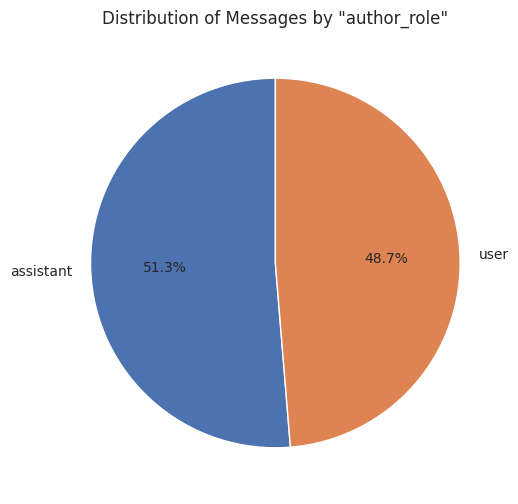

In [8]:
# Distribution of "user" vs "assistant" messages
author_role_counts = df['author_role'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
colors = sns.color_palette('deep')[0:len(author_role_counts)]
author_role_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=author_role_counts.index, colors=colors)
plt.title('Distribution of Messages by "author_role"')
plt.ylabel('')
plt.show()

Sometimes ChatGPT generates more than one possible answer for each question, so it could be the case that this split is not 50-50.

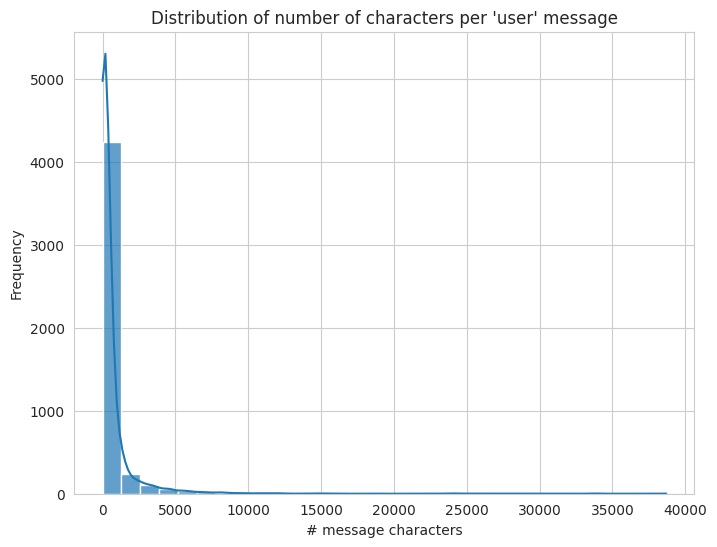

In [11]:
# Distribution of message length - "user"
# User messages tend to be shorter, as expected
plt.figure(figsize=(8, 6))
sns.histplot(df[df["author_role"] == "user"]["msg_chars_len"], bins=30, kde=True, alpha=0.7)
plt.title("Distribution of number of characters per 'user' message")
plt.xlabel("# message characters")
plt.ylabel("Frequency")
plt.show()

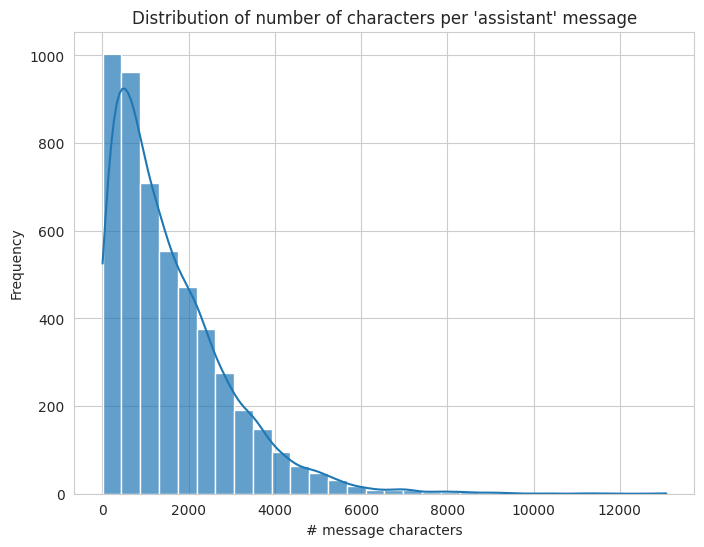

In [13]:
# Distribution of message length - "assistant"
plt.figure(figsize=(8, 6))
sns.histplot(df[df["author_role"] == "assistant"]["msg_chars_len"], bins=30, kde=True, alpha=0.7)
plt.title("Distribution of number of characters per 'assistant' message")
plt.xlabel("# message characters")
plt.ylabel("Frequency")
plt.show()

In [43]:
# Compute distribution of number of messages per conversation
message_counts = df.groupby("conv_id").size().reset_index(name='message_count')
message_counts.describe()

,message_count
count,1237.000000
mean,7.864996
std,11.551785
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,183.000000


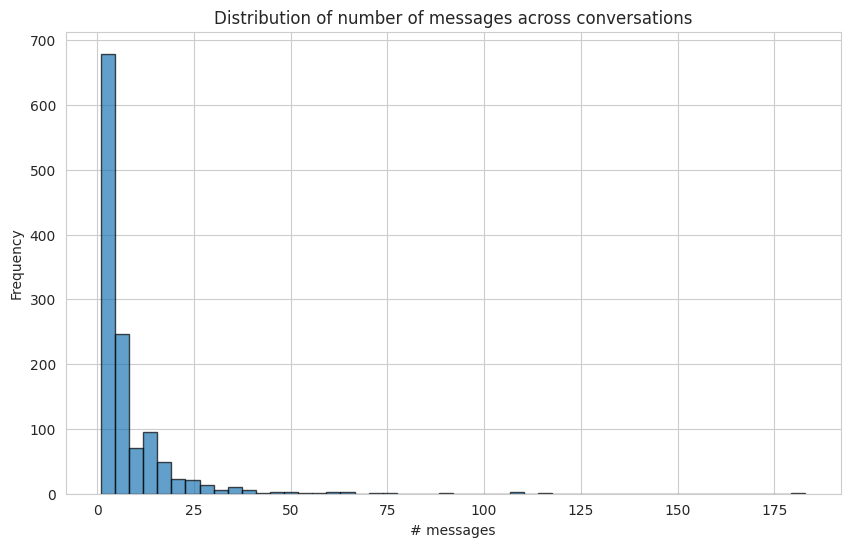

In [51]:
# Plot a histogram showing the distribution of message counts
plt.figure(figsize=(10, 6))
plt.hist(message_counts['message_count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('# messages')
plt.ylabel('Frequency')
plt.title('Distribution of number of messages across conversations')
plt.show()

My conversations with ChatGPT typically have 8 messages (includes 'user' and 'assistant').

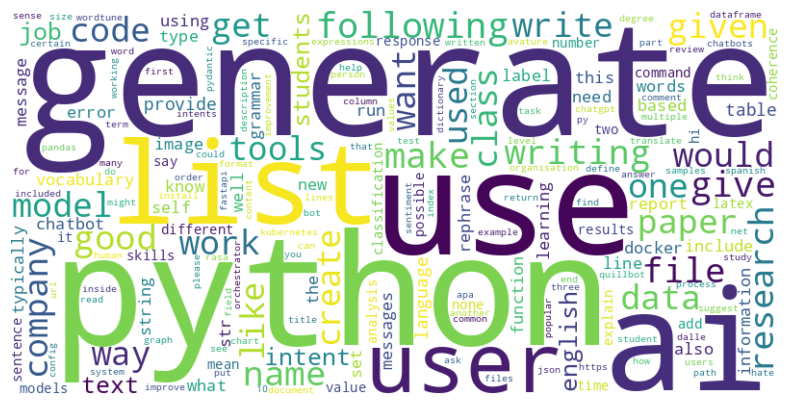

In [37]:
# WordCloud for user messages
clean_user_msgs: list[list[str]] = []
for _conv_id, conv_messages in list(df[df["author_role"] == "user"].groupby("conv_id")["message"]):
    clean_user_msgs.append([clean(cm) for cm in conv_messages])
wordcloud: WordCloud = build_wordcloud(clean_user_msgs, ignore_cm_grouping=True)
# wordcloud.words_

This list reflects the type of use I regularly do with ChatGPT:
- Most of the interactions seem to center around code generation, debugging, and NLP-related research, with "python" being the dominant programming language. There are other technologies mentioned, like "docker", "fastapi", "kubernetes" and so on, which I frequently use at work.
- Secondary Activities: I also explore tools and frameworks for API development, chatbots, and text processing.
- Broader Interests: work involving language-based tools, potentially tied to improving language skills or working on academic projects.
- Optimizing Workflows: patterns suggest leveraging LLMs to streamline repetitive tasks, debug errors, and refine workflows.

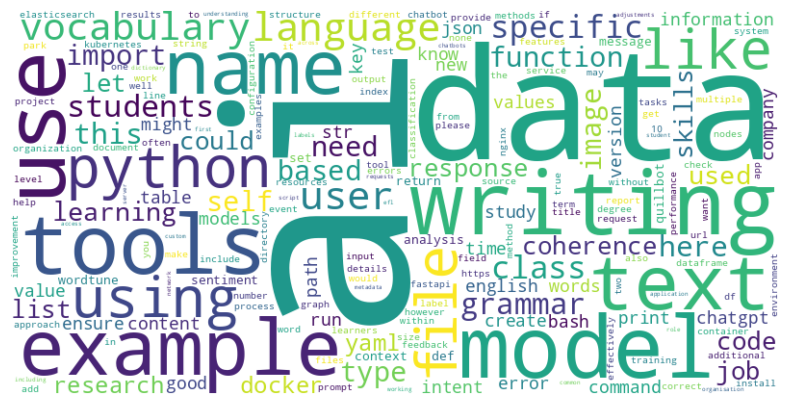

In [39]:
# WordCloud for assistant messages
clean_user_msgs: list[list[str]] = []
for _conv_id, conv_messages in list(df[df["author_role"] == "assistant"].groupby("conv_id")["message"]):
    clean_user_msgs.append([clean(cm) for cm in conv_messages])
wordcloud: WordCloud = build_wordcloud(clean_user_msgs, ignore_cm_grouping=True)
# wordcloud.words_

More relevant terms in the answers provided by ChatGPT are also centered around topics previously discussed.

### HeatMap with yearly usage

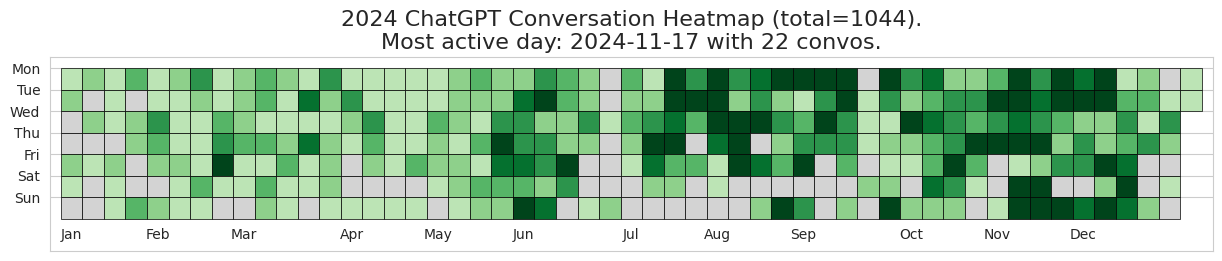

In [40]:
create_year_heatmap(proc_convs, 2024)

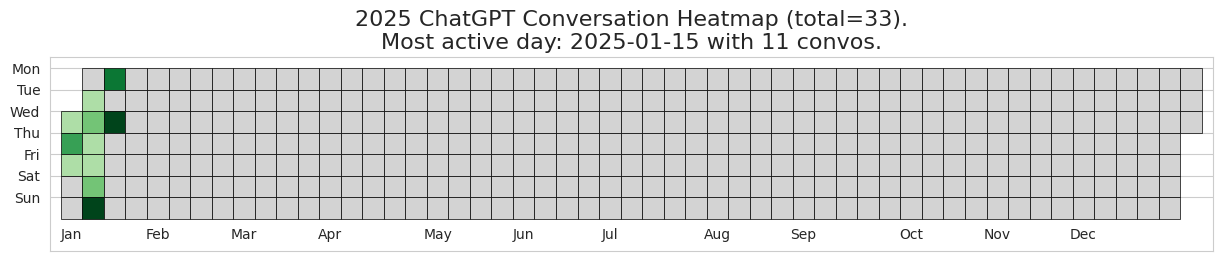

In [41]:
create_year_heatmap(proc_convs, 2025)

### Conclusions

- I use ChatGPT consistently, mostly since June of 2024 (which is probably when I started paying for the Plus subscription).
- I mostly use it during week days, but since November of 2024 I started using it considerably over weekends as well (probably on my personal/research projects).
- What do I use it for? Mostly technical stuff, but also for writing and elaboration of ideas.
- Am I becoming too dependant on it? Not necessarily. I use it to accelerate my workflow on some tasks, like getting base code generation, analysis, writing documentation and suggesting refactor ideas, and so on. However, I believe we're still better on defining architecture and solving more complex problems.